# Proyecto Minería de Datos para grades volúmenes de Información


# Clustering

In [1]:
# Import data. data_frames is a dictionary that contains all the data previously saved in an AWS-S3 bucket.

from project import data_frames
for key, values in data_frames.items():
    print(key)

energy-data/power-laws-forecasting-energy-consumption-holidays.csv
energy-data/power-laws-forecasting-energy-consumption-metadata.csv
energy-data/power-laws-forecasting-energy-consumption-submission-forecast-period.csv
energy-data/power-laws-forecasting-energy-consumption-test-data.csv
energy-data/power-laws-forecasting-energy-consumption-training-data.csv
energy-data/power-laws-forecasting-energy-consumption-weather.csv


In [2]:
# Import pyspark environment adn libraries.

!pip install pyspark
!pip install -U -q PyDrive
!sudo apt-get install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.ml.feature import Imputer


In [4]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

23/11/04 15:46:15 WARN Utils: Your hostname, codespaces-f5d2da resolves to a loopback address: 127.0.0.1; using 172.16.5.4 instead (on interface eth0)
23/11/04 15:46:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/04 15:46:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# data - frames

holidays = data_frames['energy-data/power-laws-forecasting-energy-consumption-holidays.csv']
metadata = data_frames['energy-data/power-laws-forecasting-energy-consumption-metadata.csv']
forecast = data_frames['energy-data/power-laws-forecasting-energy-consumption-submission-forecast-period.csv']
test_data = data_frames['energy-data/power-laws-forecasting-energy-consumption-test-data.csv']
train_data = data_frames['energy-data/power-laws-forecasting-energy-consumption-training-data.csv']
weather = data_frames['energy-data/power-laws-forecasting-energy-consumption-weather.csv']

In [6]:
# total_data is the mix between test, and train data sets
total_data = pd.concat([train_data, test_data])

In [7]:
# Convert the Timestamp column to datetime
total_data['Timestamp'] = pd.to_datetime(total_data['Timestamp'])

# Group by Timestamp and SiteId, and calculate the mean value
result_total_data = total_data.groupby(['SiteId', pd.Grouper(key='Timestamp', freq='H')])['Value'].median().reset_index()

result_total_data

,SiteId,Timestamp,Value
0,1,2014-09-03 00:00:00+00:00,9.096555e+05
1,1,2014-09-04 00:00:00+00:00,1.748273e+06
2,1,2014-09-05 00:00:00+00:00,NaN
3,1,2014-09-06 00:00:00+00:00,NaN
4,1,2014-09-07 00:00:00+00:00,NaN
...,...,...,...
3149111,305,2015-11-21 08:00:00+00:00,2.177838e+03
3149112,305,2015-11-21 09:00:00+00:00,4.026094e+03
3149113,305,2015-11-21 10:00:00+00:00,3.939810e+03
3149114,305,2015-11-21 11:00:00+00:00,3.958696e+03


In [8]:
# result_day is a dataframe shows the values in a frequency 1 per day
result_day= result_total_data.groupby(['SiteId', pd.to_datetime(result_total_data['Timestamp'].dt.date)])['Value'].sum().reset_index()
result_day['hourlyValue']=result_day.apply(lambda row: row['Value']/24, axis=1)
result_day

In [15]:
# Convert the Timestamp column to datetime
weather['Timestamp'] = pd.to_datetime(weather['Timestamp'])

# Group by Timestamp and SiteId, and calculate the mean temperature
result_temperature = weather.groupby(['SiteId', pd.Grouper(key='Timestamp', freq='H')])['Temperature'].median().reset_index()

result_temperature

,SiteId,Timestamp,Temperature
0,2,2013-01-01 13:00:00+00:00,21.85
1,2,2013-01-01 14:00:00+00:00,22.00
2,2,2013-01-01 15:00:00+00:00,22.00
3,2,2013-01-01 16:00:00+00:00,22.70
4,2,2013-01-01 17:00:00+00:00,22.00
...,...,...,...
1284292,57,2017-12-30 18:00:00+00:00,8.00
1284293,57,2017-12-30 19:00:00+00:00,8.70
1284294,57,2017-12-30 20:00:00+00:00,8.00
1284295,57,2017-12-30 21:00:00+00:00,7.00


In [16]:
Temperature_day= result_temperature.groupby(['SiteId', pd.to_datetime(result_temperature['Timestamp'].dt.date)])['Temperature'].median().reset_index()

In [22]:
# temp variables are used to create a total dataframe with the needed columns

temp1 = result_day.merge(Temperature_day, how = 'inner', left_on= ['Timestamp','SiteId'], right_on=['Timestamp', 'SiteId'])

(27043, 5)

In [23]:
total_merge_data = temp1.merge(metadata, how = 'inner', left_on= ['SiteId'], right_on=['SiteId'])

In [24]:
total_merge_data

,SiteId,Timestamp,Value,hourlyValue,Temperature,Surface,Sampling,BaseTemperature,MondayIsDayOff,TuesdayIsDayOff,WednesdayIsDayOff,ThursdayIsDayOff,FridayIsDayOff,SaturdayIsDayOff,SundayIsDayOff
0,2,2013-01-01,9.863965e+05,41099.855305,21.85,6098.278376,30.0,18.0,False,False,False,False,False,True,True
1,2,2013-01-02,1.052226e+06,43842.765910,20.00,6098.278376,30.0,18.0,False,False,False,False,False,True,True
2,2,2013-01-03,9.225301e+05,38438.752222,17.10,6098.278376,30.0,18.0,False,False,False,False,False,True,True
3,2,2013-01-04,9.262394e+05,38593.308226,17.00,6098.278376,30.0,18.0,False,False,False,False,False,True,True
4,2,2013-01-05,8.774980e+05,36562.415813,18.50,6098.278376,30.0,18.0,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27038,57,2017-09-24,5.484251e+05,22851.044745,18.25,700.616167,15.0,18.0,False,False,False,False,False,True,True
27039,57,2017-09-25,7.147719e+05,29782.163061,19.00,700.616167,15.0,18.0,False,False,False,False,False,True,True
27040,57,2017-09-26,6.822821e+05,28428.421164,20.25,700.616167,15.0,18.0,False,False,False,False,False,True,True
27041,57,2017-09-27,7.151552e+05,29798.134232,20.50,700.616167,15.0,18.0,False,False,False,False,False,True,True


In [25]:
# energy_data is the Data Frame with the needed columns
energy_data = total_merge_data[['SiteId', 'hourlyValue', 'Temperature', 'Surface']]
energy_data

,SiteId,hourlyValue,Temperature,Surface
0,2,41099.855305,21.85,6098.278376
1,2,43842.765910,20.00,6098.278376
2,2,38438.752222,17.10,6098.278376
3,2,38593.308226,17.00,6098.278376
4,2,36562.415813,18.50,6098.278376
...,...,...,...,...
27038,57,22851.044745,18.25,700.616167
27039,57,29782.163061,19.00,700.616167
27040,57,28428.421164,20.25,700.616167
27041,57,29798.134232,20.50,700.616167


In [26]:
energy_data_spark = spark.createDataFrame(energy_data)

/home/codespace/.python/current/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


In [27]:
energy_data_spark.show()

+------+------------------+-----------+-----------------+
|SiteId|       hourlyValue|Temperature|          Surface|
+------+------------------+-----------+-----------------+
|     2| 41099.85530538901|      21.85|6098.278376070084|
|     2| 43842.76590953585|       20.0|6098.278376070084|
|     2| 38438.75222184868|       17.1|6098.278376070084|
|     2|38593.308226343644|       17.0|6098.278376070084|
|     2|36562.415813026004|       18.5|6098.278376070084|
|     2|38627.456375728485|       18.7|6098.278376070084|
|     2|120814.59481115872|       19.0|6098.278376070084|
|     2|120990.88145617132|       18.5|6098.278376070084|
|     2|133063.28521485085|       20.5|6098.278376070084|
|     2|127743.95142526618|       22.0|6098.278376070084|
|     2|116607.74387337094|       22.0|6098.278376070084|
|     2|47835.657866690744|       21.0|6098.278376070084|
|     2| 46833.26440622998|       21.0|6098.278376070084|
|     2|135316.43336072244|       22.0|6098.278376070084|
|     2|112236

# EDA


In [28]:
energy_data_spark.summary().show()

23/11/04 15:47:36 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+------------------+------------------+------------------+
|summary|            SiteId|       hourlyValue|       Temperature|           Surface|
+-------+------------------+------------------+------------------+------------------+
|  count|             27043|             27043|             27043|             27043|
|   mean|24.026513330621604| 77764.74078552173|15.071969640942221|8080.8110070801085|
| stddev|15.580142720736013|109143.54337082528| 7.014628751213149|  9561.62262334408|
|    min|                 2|               0.0|             -11.0|14.884534437442198|
|    25%|                 9|13198.277092868075|             10.25| 1032.735063490691|
|    50%|                22|30688.138890945993|              15.0| 6098.278376070084|
|    75%|                39| 96966.13333420357|             19.65| 10985.29263411183|
|    max|                57| 864531.5992355075|              38.0| 45941.71643756564|
+-------+------------------+------------------+-------

### Valores máximos y mínimos para el cálculo de variables categóricas

In [29]:
consumomax=energy_data_spark.select(max('hourlyValue')).first()[0]
consumomax

864531.5992355075

In [30]:
valores_nulos_por_columna = energy_data_spark.select([sum(col(column).isNull().cast("int")).alias(column) for column in energy_data_spark.columns])

In [31]:
valores_nulos_por_columna.show()

+------+-----------+-----------+-------+
|SiteId|hourlyValue|Temperature|Surface|
+------+-----------+-----------+-------+
|     0|          0|          0|      0|
+------+-----------+-----------+-------+



In [32]:
valores_nan_por_columna = energy_data_spark.select([sum(isnan(col(column)).cast("int")).alias(column) for column in energy_data.columns])

In [33]:
valores_nan_por_columna.show()

+------+-----------+-----------+-------+
|SiteId|hourlyValue|Temperature|Surface|
+------+-----------+-----------+-------+
|     0|          0|          0|      0|
+------+-----------+-----------+-------+



### Se realiza la categorización de las variables para analizar los datos de forma gráfica e intuir posibles clusters.

#### Catergoría superficie



In [34]:
energy_data_spark.select(max('Surface')).first()[0]

45941.71643756564

In [35]:
energy_data_spark.select(min('Surface')).first()[0]

14.884534437442198

In [36]:
valor1=(energy_data_spark.select(max('Surface')).first()[0]-energy_data_spark.select(min('Surface')).first()[0])/3

In [37]:
valor1

15308.9439677094

In [38]:
valor2=(2*(energy_data_spark.select(max('Surface')).first()[0]-energy_data_spark.select(min('Surface')).first()[0]))/3
valor2

30617.8879354188

In [39]:
energy_data_cat=energy_data_spark.withColumn("CatSurface",
                                             when(energy_data_spark["Surface"]< valor1,"Low")
                                             .when((energy_data_spark["Surface"]>=valor1) & (energy_data_spark["Surface"]<=valor2),"Medium")
                                             .when(energy_data_spark["Surface"]>valor2,"High"))

In [40]:
energy_data_cat.show()

+------+------------------+-----------+-----------------+----------+
|SiteId|       hourlyValue|Temperature|          Surface|CatSurface|
+------+------------------+-----------+-----------------+----------+
|     2| 41099.85530538901|      21.85|6098.278376070084|       Low|
|     2| 43842.76590953585|       20.0|6098.278376070084|       Low|
|     2| 38438.75222184868|       17.1|6098.278376070084|       Low|
|     2|38593.308226343644|       17.0|6098.278376070084|       Low|
|     2|36562.415813026004|       18.5|6098.278376070084|       Low|
|     2|38627.456375728485|       18.7|6098.278376070084|       Low|
|     2|120814.59481115872|       19.0|6098.278376070084|       Low|
|     2|120990.88145617132|       18.5|6098.278376070084|       Low|
|     2|133063.28521485085|       20.5|6098.278376070084|       Low|
|     2|127743.95142526618|       22.0|6098.278376070084|       Low|
|     2|116607.74387337094|       22.0|6098.278376070084|       Low|
|     2|47835.657866690744|       

### Categoría Temperatura

In [41]:
valor1t=(energy_data_spark.select(max('Temperature')).first()[0]-energy_data_spark.select(min('Temperature')).first()[0])/3
valor1t

16.333333333333332

In [42]:
valor2t=(2*(energy_data_spark.select(max('Temperature')).first()[0]-energy_data_spark.select(min('Temperature')).first()[0]))/3
valor2t

32.666666666666664

In [45]:
energy_data_cat=energy_data_cat.withColumn("CatTemperature",
                                             when(energy_data_spark["Temperature"]< valor1t,"Low")
                                             .when((energy_data_spark["Temperature"]>=valor1t) & (energy_data_spark["Temperature"]<=valor2t),"Medium")
                                             .when(energy_data_spark["Temperature"]>valor2t,"High"))

In [46]:
energy_data_cat.show()

+------+------------------+-----------+-----------------+----------+--------------+
|SiteId|       hourlyValue|Temperature|          Surface|CatSurface|CatTemperature|
+------+------------------+-----------+-----------------+----------+--------------+
|     2| 41099.85530538901|      21.85|6098.278376070084|       Low|        Medium|
|     2| 43842.76590953585|       20.0|6098.278376070084|       Low|        Medium|
|     2| 38438.75222184868|       17.1|6098.278376070084|       Low|        Medium|
|     2|38593.308226343644|       17.0|6098.278376070084|       Low|        Medium|
|     2|36562.415813026004|       18.5|6098.278376070084|       Low|        Medium|
|     2|38627.456375728485|       18.7|6098.278376070084|       Low|        Medium|
|     2|120814.59481115872|       19.0|6098.278376070084|       Low|        Medium|
|     2|120990.88145617132|       18.5|6098.278376070084|       Low|        Medium|
|     2|133063.28521485085|       20.5|6098.278376070084|       Low|        

In [47]:
# PySpark to Pandas for better representation using Seaborn 

energy_data_pandas = energy_data_cat.toPandas()

/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

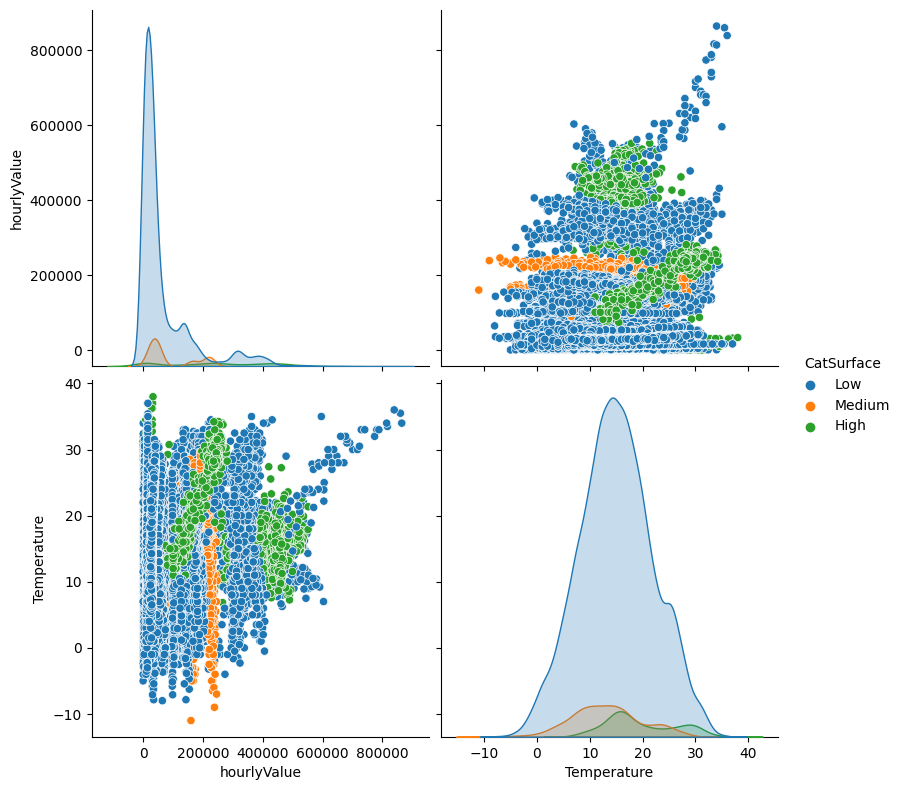

In [48]:
sns.pairplot(energy_data_pandas, hue='CatSurface', height = 4, vars= ['hourlyValue', 'Temperature'])

plt.show()

/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDty

/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/codespace/.local/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before ope

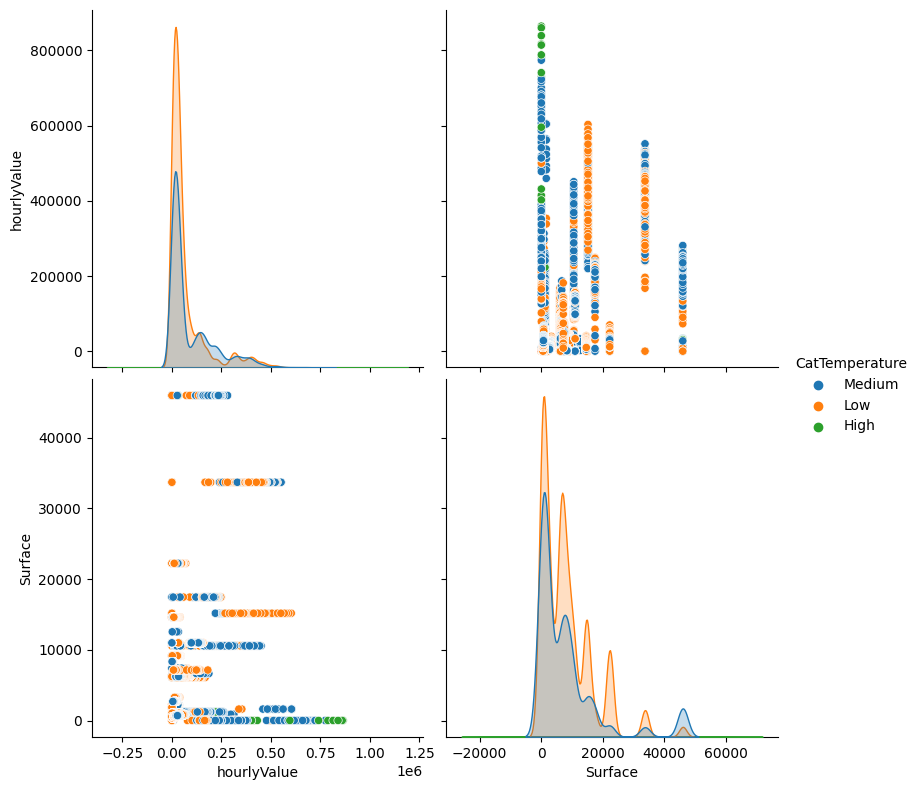

In [49]:
sns.pairplot(energy_data_pandas, hue='CatTemperature', height = 4, vars= ['hourlyValue', 'Surface'])
plt.show()

In [50]:
# Min Max Scaler

scaler = MinMaxScaler()
scaler.fit(energy_data_pandas[['hourlyValue', 'Temperature', 'Surface']])
energy_data_pandas[['hourlyValue', 'Temperature', 'Surface']] = scaler.transform(energy_data_pandas[['hourlyValue', 'Temperature', 'Surface']])
energy_data_pandas


,SiteId,hourlyValue,Temperature,Surface,CatSurface,CatTemperature
0,2,0.047540,0.670408,0.132458,Low,Medium
1,2,0.050713,0.632653,0.132458,Low,Medium
2,2,0.044462,0.573469,0.132458,Low,Medium
3,2,0.044641,0.571429,0.132458,Low,Medium
4,2,0.042292,0.602041,0.132458,Low,Medium
...,...,...,...,...,...,...
27038,57,0.026432,0.596939,0.014931,Low,Medium
27039,57,0.034449,0.612245,0.014931,Low,Medium
27040,57,0.032883,0.637755,0.014931,Low,Medium
27041,57,0.034467,0.642857,0.014931,Low,Medium


In [51]:
energy_data_spark_scaled = spark.createDataFrame(energy_data_pandas)

energy_data_spark_scaled.show()

/home/codespace/.python/current/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:485: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if should_localize and is_datetime64tz_dtype(s.dtype) and s.dt.tz is not None:


+------+--------------------+------------------+-------------------+----------+--------------+
|SiteId|         hourlyValue|       Temperature|            Surface|CatSurface|CatTemperature|
+------+--------------------+------------------+-------------------+----------+--------------+
|     2| 0.04754002669391495|0.6704081632653061|0.13245838194248025|       Low|        Medium|
|     2|0.050712739648042196|0.6326530612244897|0.13245838194248025|       Low|        Medium|
|     2| 0.04446194014867646| 0.573469387755102|0.13245838194248025|       Low|        Medium|
|     2| 0.04464071441746159|0.5714285714285714|0.13245838194248025|       Low|        Medium|
|     2| 0.04229158985670114|0.6020408163265305|0.13245838194248025|       Low|        Medium|
|     2| 0.04468021343567566|0.6061224489795918|0.13245838194248025|       Low|        Medium|
|     2|   0.139745724642099|0.6122448979591837|0.13245838194248025|       Low|        Medium|
|     2| 0.13994963464974763|0.6020408163265305|0.

# Modeladdo

### K-means Scikit Learn

In [52]:
from sklearn.cluster import KMeans

In [53]:
energy_data_pandas_cluster = energy_data_pandas[['Temperature', 'Surface', 'hourlyValue']]

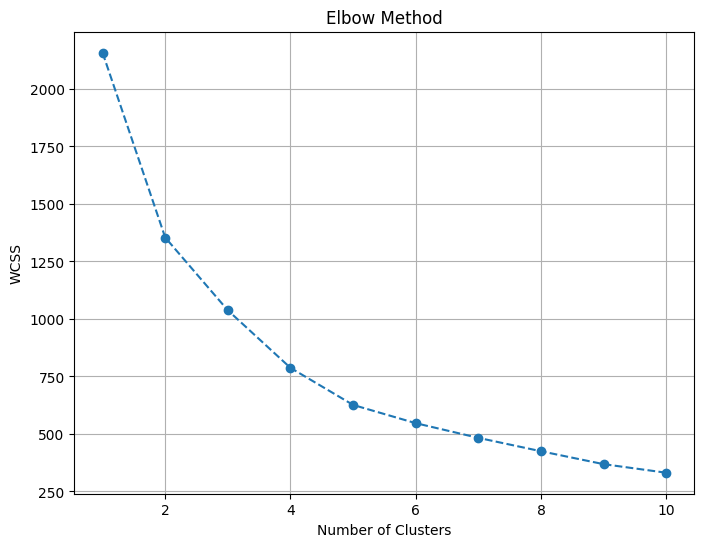

In [54]:
# Assuming you have your data in a variable named 'data'
wcss = []  # Within-Cluster Sum of Squares

# Calculate WCSS for a range of cluster numbers
for i in range(1, 11):  # Try different numbers of clusters, e.g., from 1 to 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(energy_data_pandas_cluster)  # Fit the K-Means model to your data
    wcss.append(kmeans.inertia_)  # Inertia is another name for WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()

In [55]:
kmeans = KMeans(n_clusters=4, random_state=0, n_init="auto").fit(energy_data_pandas_cluster)

/tmp/ipykernel_1281/948824013.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_data_pandas_cluster['Cluster'] = kmeans.labels_


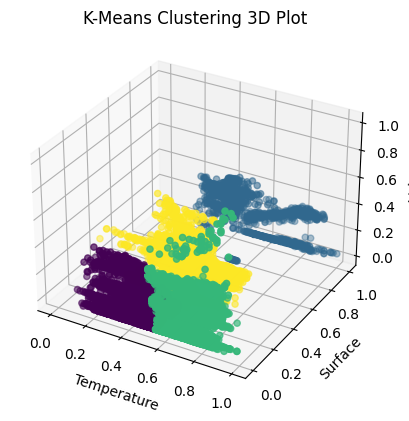

In [56]:

from mpl_toolkits.mplot3d import Axes3D  # Import the 3D toolkit


# Add the cluster labels to your DataFrame
energy_data_pandas_cluster['Cluster'] = kmeans.labels_

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the X, Y, and Z axes using your column names
x = energy_data_pandas_cluster['Temperature']
y = energy_data_pandas_cluster['Surface']
z = energy_data_pandas_cluster['hourlyValue']

# Scatter plot with cluster coloring
ax.scatter(x, y, z, c=energy_data_pandas_cluster['Cluster'], cmap='viridis')

# Set axis labels
ax.set_xlabel('Temperature')
ax.set_ylabel('Surface')
ax.set_zlabel('Value')

# Set the title
plt.title('K-Means Clustering 3D Plot')

# Show the 3D plot
plt.show()


### K-means Pyspark

In [57]:
cols_to_drop = ['CatSurface', 'CatTemperature']

energy_data_spark_ = energy_data_spark_scaled.drop(*cols_to_drop)

In [58]:
energy_data_spark_.show()

+------+--------------------+------------------+-------------------+
|SiteId|         hourlyValue|       Temperature|            Surface|
+------+--------------------+------------------+-------------------+
|     2| 0.04754002669391495|0.6704081632653061|0.13245838194248025|
|     2|0.050712739648042196|0.6326530612244897|0.13245838194248025|
|     2| 0.04446194014867646| 0.573469387755102|0.13245838194248025|
|     2| 0.04464071441746159|0.5714285714285714|0.13245838194248025|
|     2| 0.04229158985670114|0.6020408163265305|0.13245838194248025|
|     2| 0.04468021343567566|0.6061224489795918|0.13245838194248025|
|     2|   0.139745724642099|0.6122448979591837|0.13245838194248025|
|     2| 0.13994963464974763|0.6020408163265305|0.13245838194248025|
|     2| 0.15391373239858064|0.6428571428571428|0.13245838194248025|
|     2| 0.14776088177485736|0.6734693877551019|0.13245838194248025|
|     2| 0.13487967817079843|0.6734693877551019|0.13245838194248025|
|     2| 0.05533130068234766|0.653

In [59]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler

In [60]:
rango = range(2,16)
evaluator = ClusteringEvaluator()

In [61]:

# Configurar el ensamblador de características
assembler = VectorAssembler(inputCols=energy_data_spark_.columns, outputCol="features")
data = assembler.transform(energy_data_spark_)

In [62]:
cost = []
silhouette = []
 
for k in rango:
    kmeanSpark = KMeans().setK(k).setSeed(1)
    model = kmeanSpark.fit(data)
    preds = model.transform(data)
    cost.append(model.summary.trainingCost)
    silhouette.append(evaluator.evaluate(preds))

23/11/04 15:51:01 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


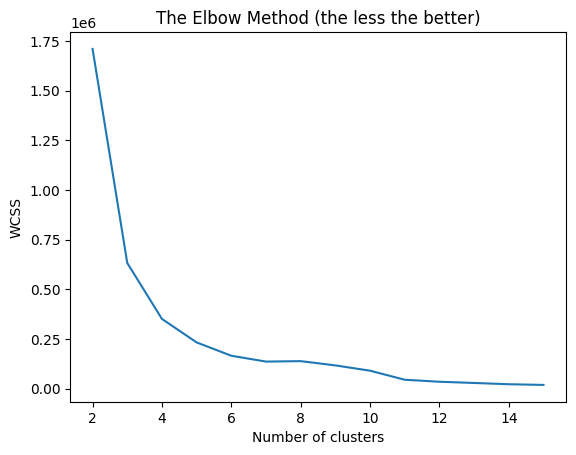

In [63]:
plt.plot(rango, cost)
plt.title('The Elbow Method (the less the better)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

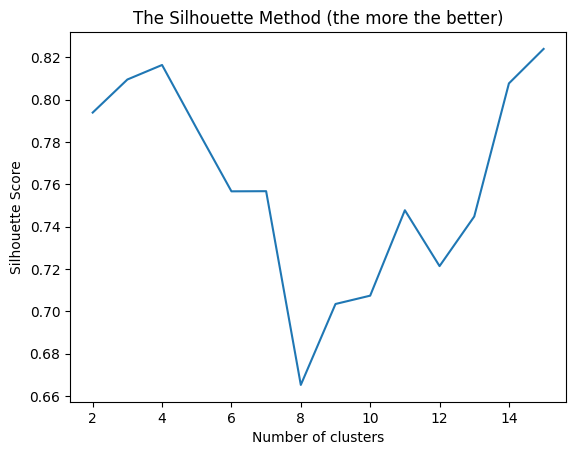

In [64]:
plt.plot(rango, silhouette)
plt.title('The Silhouette Method (the more the better)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [65]:
# Kmeans with 6 cluster

kmeanSpark = KMeans().setK(6).setSeed(1)
model = kmeanSpark.fit(data)
preds = model.transform(data)

In [75]:
preds.show()

+------+--------------------+------------------+-------------------+--------------------+----------+
|SiteId|         hourlyValue|       Temperature|            Surface|            features|prediction|
+------+--------------------+------------------+-------------------+--------------------+----------+
|     2| 0.04754002669391495|0.6704081632653061|0.13245838194248025|[2.0,0.0475400266...|         5|
|     2|0.050712739648042196|0.6326530612244897|0.13245838194248025|[2.0,0.0507127396...|         5|
|     2| 0.04446194014867646| 0.573469387755102|0.13245838194248025|[2.0,0.0444619401...|         5|
|     2| 0.04464071441746159|0.5714285714285714|0.13245838194248025|[2.0,0.0446407144...|         5|
|     2| 0.04229158985670114|0.6020408163265305|0.13245838194248025|[2.0,0.0422915898...|         5|
|     2| 0.04468021343567566|0.6061224489795918|0.13245838194248025|[2.0,0.0446802134...|         5|
|     2|   0.139745724642099|0.6122448979591837|0.13245838194248025|[2.0,0.1397457246...|  

/tmp/ipykernel_1281/474856796.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  energy_data_pandas_cluster['Cluster'] = preds_pandas.prediction


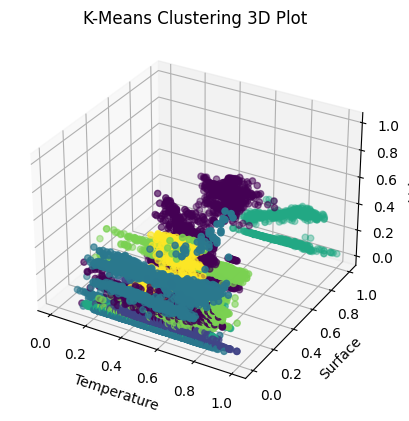

In [76]:
preds_pandas = preds.toPandas()


# Add the cluster labels to your DataFrame
energy_data_pandas_cluster['Cluster'] = preds_pandas.prediction

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define the X, Y, and Z axes using your column names
x = energy_data_pandas_cluster['Temperature']
y = energy_data_pandas_cluster['Surface']
z = energy_data_pandas_cluster['hourlyValue']

# Scatter plot with cluster coloring
ax.scatter(x, y, z, c=energy_data_pandas_cluster['Cluster'], cmap='viridis')

# Set axis labels
ax.set_xlabel('Temperature')
ax.set_ylabel('Surface')
ax.set_zlabel('Value')

# Set the title
plt.title('K-Means Clustering 3D Plot')

# Show the 3D plot
plt.show()

In [70]:
# Metrics

silhouette = evaluator.evaluate(preds)

f'The silhouette metric is: {silhouette}'

0.756662524511033

### Model Gaussian Mixture

In [66]:
from sklearn.mixture import GaussianMixture

In [67]:
energy_data_scaled_pandas = energy_data_spark_.toPandas()

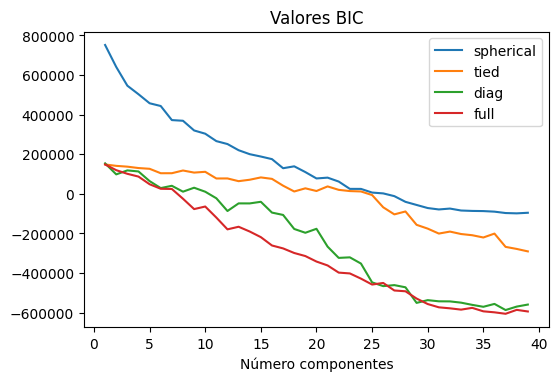

In [68]:
fig, ax = plt.subplots(figsize=(6, 3.84))

n_components = range(1, 40)
covariance_types = ['spherical', 'tied', 'diag', 'full']

for covariance_type in covariance_types:
    valores_bic = []
    
    for i in n_components:
        modelo = GaussianMixture(n_components=i, covariance_type=covariance_type)
        modelo = modelo.fit(energy_data_scaled_pandas)
        valores_bic.append(modelo.bic(energy_data_scaled_pandas))
        
    ax.plot(n_components, valores_bic, label=covariance_type)
        
ax.set_title("Valores BIC")
ax.set_xlabel("Número componentes")
ax.legend();

In [69]:
modelo_gmm = GaussianMixture(
                n_components    = 6,
                covariance_type = 'full',
                random_state    = 123, 
             )

modelo_gmm.fit(X=energy_data_scaled_pandas)

GaussianMixture(n_components=6, random_state=123)

In [71]:
# Metrics

log_probabilidad_predicha = modelo_gmm.score_samples(X=energy_data_scaled_pandas)
log_probabilidad_predicha

array([5.37604479, 6.22211211, 6.87696641, ..., 1.34254237, 1.28634253,
       1.3436143 ])